In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [32]:
!pip install --upgrade gdown
!gdown 1c-A1oTteY67zDD2S4FXrAHtqNfdrEnMf
!gdown 1pWY1KBMFBezJbpunuaePlkqTT0a9S56u

import pandas as pd
import numpy as np
import re, nltk, html, subprocess
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.sparse import lil_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
# from torchtext.data import get_tokenizer
# from torchtext.vocab import Vocab, build_vocab_from_iterator
# from torchtext.data.utils import get_tokenizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, recall_score, f1_score, confusion_matrix

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

Downloading...
From: https://drive.google.com/uc?id=1c-A1oTteY67zDD2S4FXrAHtqNfdrEnMf
To: /kaggle/working/test.csv
100%|███████████████████████████████████████| 1.50M/1.50M [00:00<00:00, 123MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pWY1KBMFBezJbpunuaePlkqTT0a9S56u
To: /kaggle/working/train.csv
100%|███████████████████████████████████████| 23.9M/23.9M [00:00<00:00, 146MB/s]
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [33]:
try:
    nltk.data.find('punkt.zip')
except:
    nltk.download('punkt', download_dir='/kaggle/working/')
    subprocess.run("unzip /usr/share/nltk_data/corpora/punkt.zip -d /usr/share/nltk_data/corpora/".split())
    nltk.data.path.append('/kaggle/input')


[nltk_data] Downloading package punkt to /kaggle/working/...
[nltk_data]   Package punkt is already up-to-date!


unzip:  cannot find or open /usr/share/nltk_data/corpora/punkt.zip, /usr/share/nltk_data/corpora/punkt.zip.zip or /usr/share/nltk_data/corpora/punkt.zip.ZIP.


In [34]:
try:
    nltk.data.find('stopwords.zip')
except:
    nltk.download('stopwords', download_dir='/kaggle/working/')
    subprocess.run("unzip /usr/share/nltk_data/corpora/stopwords.zip -d /usr/share/nltk_data/corpora/".split())
    nltk.data.path.append('/kaggle/input')

[nltk_data] Downloading package stopwords to /kaggle/working/...
[nltk_data]   Package stopwords is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/stopwords.zip


replace /usr/share/nltk_data/corpora/stopwords/dutch? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [35]:
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    subprocess.run("unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/".split())
    nltk.data.path.append('/kaggle/input')

[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip


replace /usr/share/nltk_data/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [36]:
# Read the data
train_df = pd.read_csv("train.csv")
corpus_train = train_df["Description"].to_numpy()
# tokenizer = get_tokenizer("basic_english")
# stop_words = set(stopwords.words('english'))
# stop_words.update(['.', ',', '?', '-', ':', '$', '%', '!'])
symbols = sorted(['.', ',', '?', '-', ':', ';', '$', '%', '!', 's'])
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r"([a-zA-Z]+)n[\'’]t", r"\1 not", text)
    text = re.sub(r"([iI])[\'’]m", r"\1 am", text)
    text = re.sub(r"([iI])[\'’]ll", r"\1 will", text)
    text = re.sub(r"[^a-zA-Z0-9\:\$\-\,\%\.\?\!]+", " ", text)
    text = html.unescape(text)
    text = re.sub(r"_(.*?)_", r"\1", text)
    text = re.sub(r'(\w+)-(\w+)', r'\1\2', text)
    return text

# def tokenize_text(text, stop_words, lemmatizer):
def tokenize_text(text, symbols, lemmatizer):
    tokens = word_tokenize(text)
    # tokens = [token.lower() for token in tokens]
    tokens = [token.lower() for token in tokens if token.isalpha()]  # Remove non-alphabetic tokens
    # tokens = [token for token in tokens if token not in stop_words]  # Remove stopwords
    tokens = [token for token in tokens if token not in symbols]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatize tokens
    return tokens


tokens_train = []
for sent in corpus_train:
    tokens_train.append(tokenize_text(clean_text(sent), symbols, lemmatizer))
    # tokens_train.append(sent)

train_df['Description'] = [' '.join(tokens) for tokens in tokens_train]

test_df = pd.read_csv("test.csv")
corpus_test = test_df["Description"].to_numpy()
tokens_test = []
for sent in corpus_test:
    tokens_test.append(tokenize_text(clean_text(sent), symbols, lemmatizer))
#     # tokens_test.append(sent)

test_df['Description'] = [' '.join(tokens) for tokens in tokens_test]

# from sklearn.preprocessing import LabelEncoder
# Convert class labels to numeric
# LabEnc = LabelEncoder()
# train_df['Class Index'] = LabEnc.fit_transform(train_df['Class Index'])
# test_df['Class Index'] = LabEnc.fit_transform(test_df['Class Index'])

# corpus_train = train_df["Description"].to_numpy()
# corpus_test = test_df["Description"].to_numpy()
# # Build Vocabulary
# MIN_WORD_FREQUENCY = 1
# vocab_train = build_vocab_from_iterator(tokens_train, min_freq=MIN_WORD_FREQUENCY, specials=["<unk>"])
# vocab_train.set_default_index(vocab_train["<unk>"])
# vocab_test = build_vocab_from_iterator(tokens_test, min_freq=MIN_WORD_FREQUENCY, specials=["<unk>"])
# vocab_test.set_default_index(vocab_test["<unk>"])

# print(f"Total sentences in train text: {len(tokens_train)}")
# print(f"Unique train words: {len(vocab_train)}")
# print(f"Total sentences in test text: {len(tokens_test)}")
# print(f"Unique test words: {len(vocab_test)}")

# with open("vocab_train.pkl", "wb") as f:
#     pickle.dump(vocab_train, f)
# with open("vocab_test.pkl", "wb") as f:
#     pickle.dump(vocab_test, f)

# Extract descriptions
descriptions = train_df['Description'].tolist()


# Tokenize the descriptions
tokenized_descriptions = [description.split() for description in descriptions]

# Define vocabulary
vocabulary = sorted(set(word for description in tokenized_descriptions for word in description))
word_to_index = {word: idx for idx, word in enumerate(vocabulary)}
vocab_size = len(vocabulary)
# Convert vocabulary to list for indexing
vocab_list = list(vocabulary)

In [37]:
train_df['Description']
# stop_words

0         reuters shortsellers wall street dwindling ban...
1         reuters private investment firm carlyle group ...
2         reuters soaring crude price plus worry about t...
3         reuters authority have halted oil export flow ...
4         afp tearaway world oil price toppling record a...
                                ...                        
119995    karachi reuters pakistani president pervez mus...
119996    red sox general manager theo epstein acknowled...
119997    the miami dolphin will put their courtship of ...
119998    pittsburgh at ny giant time line steelers by r...
119999    indianapolis allstar vince carter wa traded by...
Name: Description, Length: 120000, dtype: object

In [38]:
train_df['CleanDescriptionTokens'] = tokenized_descriptions
train_df['CleanDescriptionTokens']

0         [reuters, shortsellers, wall, street, dwindlin...
1         [reuters, private, investment, firm, carlyle, ...
2         [reuters, soaring, crude, price, plus, worry, ...
3         [reuters, authority, have, halted, oil, export...
4         [afp, tearaway, world, oil, price, toppling, r...
                                ...                        
119995    [karachi, reuters, pakistani, president, perve...
119996    [red, sox, general, manager, theo, epstein, ac...
119997    [the, miami, dolphin, will, put, their, courts...
119998    [pittsburgh, at, ny, giant, time, line, steele...
119999    [indianapolis, allstar, vince, carter, wa, tra...
Name: CleanDescriptionTokens, Length: 120000, dtype: object

In [39]:
def tokenize_text2(text, word_to_index):
    tokens = word_tokenize(text)
    # tokens = [token.lower() for token in tokens]
    # tokens = [token.lower() for token in tokens if token.isalpha()]  # Remove non-alphabetic tokens
    tokens = [token if token in word_to_index else 'unk' for token in tokens]
    # Remove stopwords
    # tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatize tokens
    return tokens

corpus_test2 = test_df["Description"].to_numpy()
tokens_test2 = []
for sent in corpus_test2:
    tokens_test2.append(tokenize_text2(sent, word_to_index))
#     # tokens_test.append(sent)

test_df['Description'] = [' '.join(tokens) for tokens in tokens_test2]

In [40]:
test_df['Description']

0       union representing worker at turner newall say...
1       toronto canada a second team of rocketeers com...
2       ap a company founded by a chemistry researcher...
3       ap it barely dawn when mike fitzpatrick start ...
4       ap southern california unk agency went after e...
                              ...                        
7595    ukrainian presidential candidate viktor yushch...
7596    with the supply of attractive pitching option ...
7597    like roger clemens did almost exactly eight ye...
7598    singapore doctor in the united state have warn...
7599    ebay plan to buy the apartment and home rental...
Name: Description, Length: 7600, dtype: object

In [41]:
tokenized_descriptions_test = test_df['Description'].tolist()
test_df['CleanDescriptionTokens'] = [description.split() for description in tokenized_descriptions_test]
test_df['CleanDescriptionTokens']

0       [union, representing, worker, at, turner, newa...
1       [toronto, canada, a, second, team, of, rockete...
2       [ap, a, company, founded, by, a, chemistry, re...
3       [ap, it, barely, dawn, when, mike, fitzpatrick...
4       [ap, southern, california, unk, agency, went, ...
                              ...                        
7595    [ukrainian, presidential, candidate, viktor, y...
7596    [with, the, supply, of, attractive, pitching, ...
7597    [like, roger, clemens, did, almost, exactly, e...
7598    [singapore, doctor, in, the, united, state, ha...
7599    [ebay, plan, to, buy, the, apartment, and, hom...
Name: CleanDescriptionTokens, Length: 7600, dtype: object

In [42]:
class SentenceDataset(Dataset):
    def __init__(self, sentences, labels, word_embeddings):
        self.sentences = sentences
        self.labels = labels
        self.word_embeddings = word_embeddings

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        # print(text)
        label = self.labels[idx]
        # Convert text to embedding
        embedding = torch.tensor(np.array([self.word_embeddings[word] for word in sentence]), dtype=torch.float)
        return embedding, label


def collate_fn(batch):
    inputs, labels = zip(*batch)  # Unzip the batch into inputs and labels
    inputs = pad_sequence(inputs, batch_first=True)  # Pad the sequences
    labels = torch.tensor(labels, dtype=torch.long)  # Convert labels to a tensor
    return inputs, labels


class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Assuming x is a padded sequence of embeddings
        lstm_out, (ht, ct) = self.lstm(x)
        return self.fc(ht[-1])




def AllSkLMetrics(true_labels, predicted_labels, DatasetType, WINDOW_SIZE, array):
    accuracy = accuracy_score(true_labels, predicted_labels)
    array.append(accuracy)
    print(f'Accuracy on the {DatasetType} set: {accuracy} for window_size = {WINDOW_SIZE}')

    # Additional Metrics
    print("Classification Report:")
    print(classification_report(true_labels, predicted_labels))

    print("Confusion Matrix:")
    print(confusion_matrix(true_labels, predicted_labels))

    # Micro and Macro Recall
    micro_recall = recall_score(true_labels, predicted_labels, average='micro')
    macro_recall = recall_score(true_labels, predicted_labels, average='macro')
    print(f'Micro Recall: {micro_recall}')
    print(f'Macro Recall: {macro_recall}')

    # Micro and Macro F1 Score
    micro_f1 = f1_score(true_labels, predicted_labels, average='micro')
    macro_f1 = f1_score(true_labels, predicted_labels, average='macro')
    print(f'Micro F1 Score: {micro_f1}')
    print(f'Macro F1 Score: {macro_f1}')
    print()
    print()
    print()

In [43]:
window_sizes = [1,2,3,4,5]
k = 300  # Number of dimensions for word vectors
# Build co-occurrence matrix
# co_occurrence_matrix = np.zeros((vocab_size, vocab_size))



for WINDOW_SIZE in window_sizes:
    print(f'Window Size = {WINDOW_SIZE}')
    co_occurrence_matrix = lil_matrix((vocab_size, vocab_size), dtype=np.float64)
    for description in tokenized_descriptions:
        for i, word in enumerate(description):
            center_index = word_to_index[word]
            for j in range(max(0, i - WINDOW_SIZE), min(len(description), i + WINDOW_SIZE + 1)):
                if j != i:
                    context_word = description[j]
                    context_index = word_to_index.get(context_word)
                    if context_index is not None:
                        co_occurrence_matrix[center_index,context_index] += 1
                        # co_occurrence_matrix[center_index][context_index] += 1

    print("COM")

    svd = TruncatedSVD(n_components=k)
    word_vectors = svd.fit_transform(co_occurrence_matrix)
    print("SVD")
    # Create a dictionary with word embeddings
    word_embeddings = {word: word_vectors[word_to_index[word]] for word in vocabulary}
    word_embeddings['unk'] = np.zeros(k)
    # Save the word embeddings dictionary as a PyTorch file
    torch.save(word_embeddings, f'svd-word-vectors-w={WINDOW_SIZE}.pt')




Window Size = 1
COM
SVD
Window Size = 2
COM
SVD
Window Size = 3
COM
SVD
Window Size = 4
COM
SVD
Window Size = 5
COM
SVD


In [48]:
window_sizes = [1,2,3,4,5]
val_accuracies = []
test_accuracies = []

for WINDOW_SIZE in window_sizes:
    print(f'Window Size = {WINDOW_SIZE}')
    # Access all word vectors
    word_embeddings = torch.load(f'svd-word-vectors-w={WINDOW_SIZE}.pt')
    # word_embeddings



    # Convert class labels to numeric and # Split data into training and validation sets
    LabEnc = LabelEncoder()
    train_df['Class Index'] = LabEnc.fit_transform(train_df['Class Index'])
    train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)
    test_df['Class Index'] = LabEnc.fit_transform(test_df['Class Index'])
    test_data = test_df

    model = LSTMClassifier(k, 512, len(LabEnc.classes_))
    # Assuming the use of a GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    model.to(device)



    # print(word_embeddings['explosion'])
    # text = train_data['CleanDescriptionTokens'].tolist()[0]
    # print(torch.tensor([word_embeddings[word] for word in text]))

    # Create dataset instances and # DataLoader instances
    train_dataset = SentenceDataset(train_data['CleanDescriptionTokens'].tolist(), train_data['Class Index'].tolist(), word_embeddings)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

    val_dataset = SentenceDataset(val_data['CleanDescriptionTokens'].tolist(), val_data['Class Index'].tolist(), word_embeddings)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

    test_dataset = SentenceDataset(test_data['CleanDescriptionTokens'].tolist(), test_data['Class Index'].tolist(), word_embeddings)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)


    # Set the model in training mode
    num_epochs = 5
    best_val_accuracy = 0
    best_model = None
    print("DL")
    for epoch in tqdm(range(num_epochs)):
        print(epoch+1, " train")
        model.train()
        running_loss = 0.0
        for descriptions, labels in train_loader:
            descriptions, labels = descriptions.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(descriptions)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation
        print("eval")
        model.eval()
        correct = 0
        total = 0

        # Disable gradient calculation during validation
        with torch.no_grad():
            for descriptions, labels in val_loader:  # Using train_loader for validation too
                descriptions, labels = descriptions.to(device), labels.to(device)
                outputs = model(descriptions)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss/len(train_loader)}, Validation Accuracy: {val_accuracy}")
        
        # Save the best model based on validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = model.state_dict()
            # Save the trained model
            torch.save(best_model, f'svd-classification-model-w={WINDOW_SIZE}.pt')
            
        # Set the model back in training mode
        model.train()
        
    print()
    print("SL")

    # Load the saved model state dictionary
    model.load_state_dict(torch.load(f'svd-classification-model-w={WINDOW_SIZE}.pt'))
    model.to(device)
    print()

    # Evaluation on the val set
    print("val")
    model.eval()
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for descriptions, labels in tqdm(val_loader):
            descriptions, labels = descriptions.to(device), labels.to(device)
            outputs = model(descriptions)
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

#     test_accuracy = correct / total
#     test_accuracies.append(test_accuracy)
#     print(f'Accuracy on the test set: {test_accuracy} for window_size = {window_size}')
    AllSkLMetrics(true_labels, predicted_labels, 'val', WINDOW_SIZE, val_accuracies)



    # Evaluation on the test set
    print("test")
    model.eval()
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for descriptions, labels in tqdm(test_loader):
            descriptions, labels = descriptions.to(device), labels.to(device)
            outputs = model(descriptions)
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

#     test_accuracy = correct / total
#     test_accuracies.append(test_accuracy)
#     print(f'Accuracy on the test set: {test_accuracy} for window_size = {window_size}')
    AllSkLMetrics(true_labels, predicted_labels, 'test', WINDOW_SIZE, test_accuracies)

Window Size = 1
DL


  0%|          | 0/5 [00:00<?, ?it/s]

1  train
eval


 20%|██        | 1/5 [00:38<02:33, 38.30s/it]

Epoch 1/5, Training Loss: 0.852764750863115, Validation Accuracy: 0.767875
2  train
eval


 40%|████      | 2/5 [01:16<01:54, 38.29s/it]

Epoch 2/5, Training Loss: 0.6115492423921823, Validation Accuracy: 0.7923333333333333
3  train
eval


 60%|██████    | 3/5 [01:54<01:16, 38.34s/it]

Epoch 3/5, Training Loss: 0.581640526180466, Validation Accuracy: 0.7895833333333333
4  train
eval


 80%|████████  | 4/5 [02:33<00:38, 38.37s/it]

Epoch 4/5, Training Loss: 0.5518011406908433, Validation Accuracy: 0.8016666666666666
5  train
eval


100%|██████████| 5/5 [03:11<00:00, 38.38s/it]


Epoch 5/5, Training Loss: 0.5776388226846854, Validation Accuracy: 0.7797083333333333
SL

val


100%|██████████| 750/750 [00:04<00:00, 163.87it/s]


Accuracy on the val set: 0.8016666666666666 for window_size = 1
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.80      5956
           1       0.87      0.91      0.89      6058
           2       0.75      0.76      0.75      5911
           3       0.79      0.71      0.75      6075

    accuracy                           0.80     24000
   macro avg       0.80      0.80      0.80     24000
weighted avg       0.80      0.80      0.80     24000

Confusion Matrix:
[[4917  367  433  239]
 [ 279 5540  110  129]
 [ 509  169 4483  750]
 [ 558  257  960 4300]]
Micro Recall: 0.8016666666666666
Macro Recall: 0.801570684212283
Micro F1 Score: 0.8016666666666666
Macro F1 Score: 0.8002316280118449



test


100%|██████████| 238/238 [00:01<00:00, 166.06it/s]


Accuracy on the test set: 0.8057894736842105 for window_size = 1
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1900
           1       0.87      0.92      0.90      1900
           2       0.76      0.75      0.76      1900
           3       0.80      0.72      0.76      1900

    accuracy                           0.81      7600
   macro avg       0.80      0.81      0.80      7600
weighted avg       0.80      0.81      0.80      7600

Confusion Matrix:
[[1581  117  133   69]
 [  91 1746   31   32]
 [ 161   62 1428  249]
 [ 169   74  288 1369]]
Micro Recall: 0.8057894736842105
Macro Recall: 0.8057894736842105
Micro F1 Score: 0.8057894736842105
Macro F1 Score: 0.8045215166898371



Window Size = 2
DL


  0%|          | 0/5 [00:00<?, ?it/s]

1  train
eval


 20%|██        | 1/5 [00:38<02:34, 38.70s/it]

Epoch 1/5, Training Loss: 0.6483001074592273, Validation Accuracy: 0.8152083333333333
2  train
eval


 40%|████      | 2/5 [01:17<01:55, 38.60s/it]

Epoch 2/5, Training Loss: 0.4964836343800028, Validation Accuracy: 0.8333333333333334
3  train
eval


 60%|██████    | 3/5 [01:55<01:17, 38.62s/it]

Epoch 3/5, Training Loss: 0.47749319673081236, Validation Accuracy: 0.812
4  train
eval


 80%|████████  | 4/5 [02:34<00:38, 38.61s/it]

Epoch 4/5, Training Loss: 0.4767883803471923, Validation Accuracy: 0.8339166666666666
5  train
eval


100%|██████████| 5/5 [03:12<00:00, 38.58s/it]


Epoch 5/5, Training Loss: 0.4636848146195213, Validation Accuracy: 0.8151666666666667
SL

val


100%|██████████| 750/750 [00:04<00:00, 165.84it/s]


Accuracy on the val set: 0.8339166666666666 for window_size = 2
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      5956
           1       0.89      0.93      0.91      6058
           2       0.78      0.80      0.79      5911
           3       0.80      0.79      0.79      6075

    accuracy                           0.83     24000
   macro avg       0.83      0.83      0.83     24000
weighted avg       0.83      0.83      0.83     24000

Confusion Matrix:
[[4849  360  429  318]
 [ 197 5635  110  116]
 [ 283  136 4756  736]
 [ 269  211  821 4774]]
Micro Recall: 0.8339166666666666
Macro Recall: 0.8336892978987819
Micro F1 Score: 0.8339166666666666
Macro F1 Score: 0.8333824955241906



test


100%|██████████| 238/238 [00:01<00:00, 167.45it/s]


Accuracy on the test set: 0.8338157894736842 for window_size = 2
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1900
           1       0.90      0.93      0.91      1900
           2       0.78      0.79      0.79      1900
           3       0.79      0.81      0.80      1900

    accuracy                           0.83      7600
   macro avg       0.83      0.83      0.83      7600
weighted avg       0.83      0.83      0.83      7600

Confusion Matrix:
[[1539  102  150  109]
 [  66 1762   36   36]
 [  87   47 1504  262]
 [  81   53  234 1532]]
Micro Recall: 0.8338157894736842
Macro Recall: 0.8338157894736843
Micro F1 Score: 0.8338157894736842
Macro F1 Score: 0.8336876876271059



Window Size = 3
DL


  0%|          | 0/5 [00:00<?, ?it/s]

1  train
eval


 20%|██        | 1/5 [00:39<02:37, 39.40s/it]

Epoch 1/5, Training Loss: 0.6074001341561477, Validation Accuracy: 0.8136666666666666
2  train
eval


 40%|████      | 2/5 [01:18<01:58, 39.46s/it]

Epoch 2/5, Training Loss: 0.4791638012950619, Validation Accuracy: 0.8351666666666666
3  train
eval


 60%|██████    | 3/5 [01:58<01:18, 39.35s/it]

Epoch 3/5, Training Loss: 0.4508361997331182, Validation Accuracy: 0.8389166666666666
4  train
eval


 80%|████████  | 4/5 [02:37<00:39, 39.37s/it]

Epoch 4/5, Training Loss: 0.4495208443328738, Validation Accuracy: 0.8457916666666667
5  train
eval


100%|██████████| 5/5 [03:17<00:00, 39.43s/it]


Epoch 5/5, Training Loss: 0.4595630116586884, Validation Accuracy: 0.8448333333333333
SL

val


100%|██████████| 750/750 [00:04<00:00, 157.96it/s]


Accuracy on the val set: 0.8457916666666667 for window_size = 3
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      5956
           1       0.89      0.95      0.92      6058
           2       0.83      0.76      0.80      5911
           3       0.79      0.84      0.81      6075

    accuracy                           0.85     24000
   macro avg       0.85      0.85      0.84     24000
weighted avg       0.85      0.85      0.84     24000

Confusion Matrix:
[[4898  348  379  331]
 [  96 5785   30  147]
 [ 307  174 4517  913]
 [ 258  206  512 5099]]
Micro Recall: 0.8457916666666667
Macro Recall: 0.8452024220494637
Micro F1 Score: 0.8457916666666667
Macro F1 Score: 0.8446813976629435



test


100%|██████████| 238/238 [00:01<00:00, 160.52it/s]


Accuracy on the test set: 0.8413157894736842 for window_size = 3
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.85      1900
           1       0.89      0.95      0.92      1900
           2       0.83      0.76      0.79      1900
           3       0.77      0.85      0.81      1900

    accuracy                           0.84      7600
   macro avg       0.84      0.84      0.84      7600
weighted avg       0.84      0.84      0.84      7600

Confusion Matrix:
[[1543  106  135  116]
 [  45 1803   17   35]
 [  88   57 1436  319]
 [  76   64  148 1612]]
Micro Recall: 0.8413157894736842
Macro Recall: 0.8413157894736842
Micro F1 Score: 0.8413157894736842
Macro F1 Score: 0.84052401610993



Window Size = 4
DL


  0%|          | 0/5 [00:00<?, ?it/s]

1  train
eval


 20%|██        | 1/5 [00:38<02:34, 38.53s/it]

Epoch 1/5, Training Loss: 0.5729669326146444, Validation Accuracy: 0.839875
2  train
eval


 40%|████      | 2/5 [01:16<01:55, 38.45s/it]

Epoch 2/5, Training Loss: 0.4475169484317303, Validation Accuracy: 0.8403333333333334
3  train
eval


 60%|██████    | 3/5 [01:55<01:17, 38.58s/it]

Epoch 3/5, Training Loss: 0.42645969009151063, Validation Accuracy: 0.8550416666666667
4  train
eval


 80%|████████  | 4/5 [02:34<00:38, 38.55s/it]

Epoch 4/5, Training Loss: 0.41940271618713937, Validation Accuracy: 0.8483333333333334
5  train
eval


100%|██████████| 5/5 [03:12<00:00, 38.52s/it]


Epoch 5/5, Training Loss: 0.4163943541025122, Validation Accuracy: 0.8420416666666667
SL

val


100%|██████████| 750/750 [00:04<00:00, 165.55it/s]


Accuracy on the val set: 0.8550416666666667 for window_size = 4
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      5956
           1       0.90      0.94      0.92      6058
           2       0.83      0.79      0.81      5911
           3       0.81      0.84      0.83      6075

    accuracy                           0.86     24000
   macro avg       0.85      0.85      0.85     24000
weighted avg       0.85      0.86      0.85     24000

Confusion Matrix:
[[5010  301  367  278]
 [ 149 5707   98  104]
 [ 298  144 4686  783]
 [ 291  155  511 5118]]
Micro Recall: 0.8550416666666667
Macro Recall: 0.8546142633853169
Micro F1 Score: 0.8550416666666667
Macro F1 Score: 0.8543280624798004



test


100%|██████████| 238/238 [00:01<00:00, 167.18it/s]


Accuracy on the test set: 0.8544736842105263 for window_size = 4
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      1900
           1       0.91      0.94      0.93      1900
           2       0.82      0.78      0.80      1900
           3       0.81      0.85      0.83      1900

    accuracy                           0.85      7600
   macro avg       0.85      0.85      0.85      7600
weighted avg       0.85      0.85      0.85      7600

Confusion Matrix:
[[1610   92  115   83]
 [  53 1791   37   19]
 [  93   48 1487  272]
 [  86   41  167 1606]]
Micro Recall: 0.8544736842105263
Macro Recall: 0.8544736842105264
Micro F1 Score: 0.8544736842105263
Macro F1 Score: 0.8539808058341799



Window Size = 5
DL


  0%|          | 0/5 [00:00<?, ?it/s]

1  train
eval


 20%|██        | 1/5 [00:40<02:40, 40.01s/it]

Epoch 1/5, Training Loss: 0.6355001035407185, Validation Accuracy: 0.838875
2  train
eval


 40%|████      | 2/5 [01:19<01:59, 39.79s/it]

Epoch 2/5, Training Loss: 0.44717856097469727, Validation Accuracy: 0.842375
3  train
eval


 60%|██████    | 3/5 [01:59<01:19, 39.70s/it]

Epoch 3/5, Training Loss: 0.4283107348630826, Validation Accuracy: 0.8537083333333333
4  train
eval


 80%|████████  | 4/5 [02:38<00:39, 39.58s/it]

Epoch 4/5, Training Loss: 0.40998494550089043, Validation Accuracy: 0.8576666666666667
5  train
eval


100%|██████████| 5/5 [03:18<00:00, 39.64s/it]


Epoch 5/5, Training Loss: 0.39662030941744647, Validation Accuracy: 0.8555416666666666
SL

val


100%|██████████| 750/750 [00:04<00:00, 159.96it/s]


Accuracy on the val set: 0.8576666666666667 for window_size = 5
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.81      0.86      5956
           1       0.93      0.95      0.94      6058
           2       0.80      0.82      0.81      5911
           3       0.80      0.85      0.82      6075

    accuracy                           0.86     24000
   macro avg       0.86      0.86      0.86     24000
weighted avg       0.86      0.86      0.86     24000

Confusion Matrix:
[[4831  246  471  408]
 [  92 5728   95  143]
 [ 193   84 4853  781]
 [ 182   79  642 5172]]
Micro Recall: 0.8576666666666667
Macro Recall: 0.8572527791117325
Micro F1 Score: 0.8576666666666667
Macro F1 Score: 0.8577471310726379



test


100%|██████████| 238/238 [00:01<00:00, 156.70it/s]

Accuracy on the test set: 0.8501315789473685 for window_size = 5
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      1900
           1       0.94      0.93      0.94      1900
           2       0.79      0.80      0.80      1900
           3       0.79      0.86      0.82      1900

    accuracy                           0.85      7600
   macro avg       0.85      0.85      0.85      7600
weighted avg       0.85      0.85      0.85      7600

Confusion Matrix:
[[1533   71  163  133]
 [  40 1776   37   47]
 [  84   26 1527  263]
 [  51   25  199 1625]]
Micro Recall: 0.8501315789473685
Macro Recall: 0.8501315789473683
Micro F1 Score: 0.8501315789473685
Macro F1 Score: 0.8505706111686384





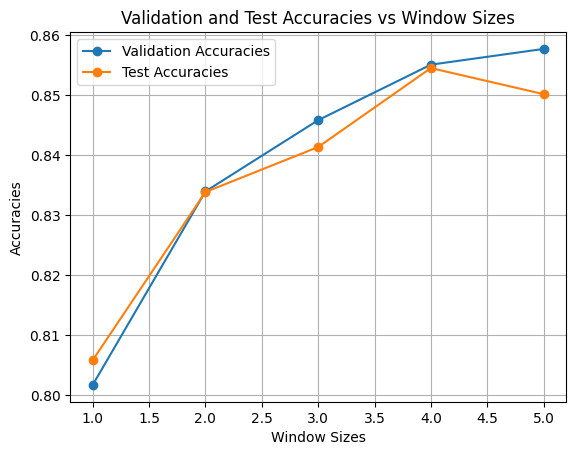

In [49]:
# Plot
plt.plot(window_sizes, val_accuracies, marker='o', label='Validation Accuracies')
plt.plot(window_sizes, test_accuracies, marker='o', label='Test Accuracies')
plt.xlabel('Window Sizes')
plt.ylabel('Accuracies')
plt.title('Validation and Test Accuracies vs Window Sizes')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# window_sizes = [1,2,3,4,5]
# test_accuracies = []
# k = 300  # Number of dimensions for word vectors
# for window_size in window_sizes:
#     # Access all word vectors
#     word_embeddings = torch.load(f'svd-word-vectors-w={window_size}.pt')
#     # word_embeddings



#     # Convert class labels to numeric and # Split data into training and validation sets
#     LabEnc = LabelEncoder()
#     test_df['Class Index'] = LabEnc.fit_transform(test_df['Class Index'])
#     test_data = test_df

#     test_dataset = SentenceDataset(test_data['CleanDescriptionTokens'].tolist(), test_data['Class Index'].tolist(), word_embeddings)
#     test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
#     # Load the saved model state dictionary
#     model.load_state_dict(torch.load(f'svd-classification-model-w={window_size}.pt'))



#     # Evaluation on the test set
#     print("test")
#     from sklearn.metrics import accuracy_score, classification_report, recall_score, f1_score, confusion_matrix
#     model.eval()
#     correct = 0
#     total = 0
#     true_labels = []
#     predicted_labels = []

#     with torch.no_grad():
#         for descriptions, labels in test_loader:
#             descriptions, labels = descriptions.to(device), labels.to(device)
#             outputs = model(descriptions)
#             _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
#             true_labels.extend(labels.cpu().numpy())
#             predicted_labels.extend(predicted.cpu().numpy())
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

# #     test_accuracy = correct / total
# #     test_accuracies.append(test_accuracy)
# #     print(f'Accuracy on the test set: {test_accuracy} for window_size = {window_size}')

#     test_accuracy = accuracy_score(true_labels, predicted_labels)
#     test_accuracies.append(test_accuracy)
#     print(f'Accuracy on the test set: {test_accuracy} for window_size = {window_size}')

#     # Additional Metrics
#     print("Classification Report:")
#     print(classification_report(true_labels, predicted_labels))

#     print("Confusion Matrix:")
#     print(confusion_matrix(true_labels, predicted_labels))

#     # Micro and Macro Recall
#     micro_recall = recall_score(true_labels, predicted_labels, average='micro')
#     macro_recall = recall_score(true_labels, predicted_labels, average='macro')
#     print(f'Micro Recall: {micro_recall}')
#     print(f'Macro Recall: {macro_recall}')

#     # Micro and Macro F1 Score
#     micro_f1 = f1_score(true_labels, predicted_labels, average='micro')
#     macro_f1 = f1_score(true_labels, predicted_labels, average='macro')
#     print(f'Micro F1 Score: {micro_f1}')
#     print(f'Macro F1 Score: {macro_f1}')

In [50]:
!zip -r svd.zip /kaggle/working/sv*
from IPython.display import FileLink
FileLink(r'svd.zip')

  adding: kaggle/working/ (stored 0%)
  adding: kaggle/working/svd-word-vectors-w=2.pt (deflated 24%)
  adding: kaggle/working/corpora/ (stored 0%)
  adding: kaggle/working/corpora/stopwords/ (stored 0%)
  adding: kaggle/working/corpora/stopwords/dutch (deflated 44%)
  adding: kaggle/working/corpora/stopwords/arabic (deflated 64%)
  adding: kaggle/working/corpora/stopwords/finnish (deflated 65%)
  adding: kaggle/working/corpora/stopwords/kazakh (deflated 70%)
  adding: kaggle/working/corpora/stopwords/romanian (deflated 57%)
  adding: kaggle/working/corpora/stopwords/catalan (deflated 55%)
  adding: kaggle/working/corpora/stopwords/hungarian (deflated 51%)
  adding: kaggle/working/corpora/stopwords/italian (deflated 62%)
  adding: kaggle/working/corpora/stopwords/russian (deflated 58%)
  adding: kaggle/working/corpora/stopwords/turkish (deflated 38%)
  adding: kaggle/working/corpora/stopwords/chinese (deflated 51%)
  adding: kaggle/working/corpora/stopwords/spanish (deflated 65%)
  add

/kaggle/working/file.zip

#1

In [ ]:
# # Load the training data
# train_data = pd.read_csv("train.csv")


# # Function to clean text
# def clean_text(text):
#     # Remove punctuation and special characters
#     text = re.sub(r"[^a-zA-Z\s]", "", text)
#     # Convert text to lowercase
#     text = text.lower()
#     # Tokenize the text
#     tokens = word_tokenize(text)
#     # Remove stopwords
#     stop_words = set(stopwords.words("english"))
#     filtered_tokens = [word for word in tokens if word not in stop_words]
#     # Lemmatize the words
#     lemmatizer = WordNetLemmatizer()
#     lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
#     # Join the tokens back into a single string
#     clean_text = " ".join(lemmatized_tokens)
#     return clean_text

# # Apply the cleaning function to the Description column
# train_data['Description'] = train_data['Description'].apply(clean_text)

# # Tokenize the text data and build a vocabulary
# class Tokenizer:
#     def __init__(self):
#         self.vocab = {}
#         self.index_to_word = []
#         self.word_to_index = {}

#     def tokenize(self, text):
#         return text.split()

#     def build_vocab(self, texts):
#         word_counts = Counter()
#         for text in texts:
#             tokens = self.tokenize(text)
#             word_counts.update(tokens)

#         for word in word_counts:
#             self.vocab[word] = len(self.vocab)
#             self.index_to_word.append(word)
#             self.word_to_index[word] = len(self.vocab) - 1

#     def text_to_indices(self, text):
#         tokens = self.tokenize(text)
#         return [self.word_to_index[token] for token in tokens if token in self.word_to_index]



# tokenizer = Tokenizer()
# tokenizer.build_vocab(train_data['Description'])

# # Create a co-occurrence matrix
# def build_co_occurrence_matrix(texts, vocab_size, window_size=5):
#     co_occurrences = Counter()
#     for text in texts:
#         indices = tokenizer.text_to_indices(text)
#         for i, center_word in enumerate(indices):
#             context_words = indices[max(0, i - window_size):i] + indices[i + 1:i + window_size + 1]
#             for context_word in context_words:
#                 co_occurrences[(center_word, context_word)] += 1

#     rows, cols, data = [], [], []
#     for (row, col), count in co_occurrences.items():
#         rows.append(row)
#         cols.append(col)
#         data.append(count)

#     co_occurrence_matrix = coo_matrix((data, (rows, cols)), shape=(vocab_size, vocab_size))
#     return co_occurrence_matrix

# co_occurrence_matrix = build_co_occurrence_matrix(train_data['Description'], vocab_size=len(tokenizer.vocab))

# co_occurrence_matrix

In [ ]:
# tokenizer.vocab

In [ ]:

# # Apply Singular Value Decomposition
# def apply_svd(co_occurrence_matrix, embedding_size=300):
#     U, _, _ = torch.svd(torch.Tensor(co_occurrence_matrix.toarray()))
#     word_embeddings = U[:, :embedding_size]
#     return word_embeddings

# word_embeddings = apply_svd(co_occurrence_matrix)

# # Save the word embeddings
# torch.save(word_embeddings, "svd-word-vectors.pt")

In [ ]:
# import torch
# import pandas as pd
# import numpy as np
# import re
# from collections import Counter
# from nltk.tokenize import word_tokenize
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.decomposition import TruncatedSVD
# from nltk.corpus import stopwords
# import nltk

# # Download NLTK resources
# nltk.download('punkt')
# nltk.download('stopwords')

# # Load data
# train_df = pd.read_csv('train.csv')

# # Function to clean and tokenize text
# def clean_text(text):
#     # Remove non-alphabetic characters and convert to lowercase
#     text = re.sub(r'[^a-zA-Z]', ' ', text.lower())
#     # Tokenize text
#     tokens = word_tokenize(text)
#     # Filter out stopwords
#     stop_words = set(stopwords.words('english'))
#     tokens = [word for word in tokens if word not in stop_words]
#     return tokens

# # Clean and tokenize the 'Description' column
# train_df['Description'] = train_df['Description'].apply(clean_text)

# # Flatten the list of tokens
# all_words = [word for sublist in train_df['Description'] for word in sublist]

# # Create a vocabulary and count the occurrences of each word
# word_counts = Counter(all_words)

# # Mapping from word to index
# word_to_index = {word: i for i, (word, _) in enumerate(word_counts.items())}

# # Mapping from index to word
# index_to_word = {i: word for word, i in word_to_index.items()}

# # Construct co-occurrence matrix
# window_size = 5  # Choose a window size for co-occurrence
# vocab_size = len(word_to_index)
# co_occurrence_matrix = np.zeros((vocab_size, vocab_size))

# for description in train_df['Description']:
#     for i, word in enumerate(description):
#         for j in range(max(i - window_size, 0), min(i + window_size, len(description))):
#             if i != j:
#                 target_word_index = word_to_index[word]
#                 context_word = description[j]
#                 context_word_index = word_to_index[context_word]
#                 co_occurrence_matrix[target_word_index][context_word_index] += 1

# # Convert co-occurrence matrix to torch tensor
# co_occurrence_tensor = torch.from_numpy(co_occurrence_matrix)

# # Apply SVD
# num_dimensions = 300  # Choose the number of dimensions for word vectors
# svd = TruncatedSVD(n_components=num_dimensions)
# word_embeddings = svd.fit_transform(co_occurrence_tensor)

# # Convert word embeddings to torch tensor
# word_embeddings_tensor = torch.from_numpy(word_embeddings)

# # Save word embeddings and mappings
# torch.save(word_embeddings_tensor, 'word_embeddings.pt')
# torch.save(word_to_index, 'word_to_index.pt')
# torch.save(index_to_word, 'index_to_word.pt')

# print("Word embeddings trained using SVD and saved successfully.")


In [ ]:
# from collections import Counter
# from tqdm import tqdm
# # Build co-occurrence matrix
# def build_co_occurrence_matrix(corpus, vocab_size, window_size=5):
#     co_occurrences = torch.zeros(vocab_size, vocab_size)
#     word_counts = Counter()

#     for text in tqdm(corpus, desc="Building Co-occurrence Matrix"):
#         tokens = text.split()
#         word_counts.update(tokens)
#         for i, target_word in enumerate(tokens):
#             target_index = word_to_index[target_word]
#             context_words = tokens[max(0, i - window_size): i] + tokens[i + 1: min(i + window_size + 1, len(tokens))]
#             for context_word in context_words:
#                 context_index = word_to_index[context_word]
#                 co_occurrences[target_index][context_index] += 1

#     return co_occurrences, word_counts

# # Convert words to indices and build vocabulary
# corpus = train_df['Description'].tolist()
# word_counts = Counter()
# for text in corpus:
#     word_counts.update(text.split())

# vocab = [word for word, _ in word_counts.most_common()]
# word_to_index = {word: i for i, word in enumerate(vocab)}
# index_to_word = {i: word for i, word in enumerate(vocab)}
# vocab_size = len(vocab)

# # co_occurrence_matrix, word_counts = build_co_occurrence_matrix(corpus, vocab_size)
# print(vocab_size)

In [ ]:
# len(word_to_index.keys())

In [ ]:
# co_occurrence_matrix

In [ ]:
# # Create DataFrame from co-occurrence matrix
# co_occurrence_df = pd.DataFrame(co_occurrence_matrix.toarray(), index=vocab_list, columns=vocab_list)

# co_occurrence_df

In [ ]:
# len(vocab_list)

In [ ]:
# df_train_new = pd.DataFrame(co_occurrence_matrix, index=word2idx.keys(), columns=word2idx.keys())
# df_train_new

In [ ]:
# co_occurrence_df['pasty']['pudgy']

In [ ]:
# # Perform Singular Value Decomposition (SVD)
# k = 100  # Number of dimensions for word vectors
# U, S, Vt = svds(co_occurrence_matrix, k=k)
# # print(U.shape, S.shape, Vt.shape)
# # U_new = U[:, ::-1]
# # S_new = np.diag(S[::-1])
# # Vt_new = Vt[::-1, :]
# # print(U_new.shape, S_new.shape, Vt_new.shape)

In [ ]:
# U_new

In [ ]:
# S_new

In [ ]:
# # US = U_new*S_new
# # torch.save(word_vectors, 'svd-word-vectors.pt')
# # word_vectors = np.dot(U_new,S_new)
# word_vectors = U
# # U.shape

In [ ]:
# word_embeddings['unk']

In [ ]:
# from sklearn.metrics.pairwise import cosine_similarity

# # Assuming 'word1' and 'word2' are the words for which you want to calculate similarity
# word1 = 'monday'
# word2 = 'tuesday'

# # Get the word vectors for the given words
# vector1 = word_embeddings[word1]
# vector2 = word_embeddings[word2]
# # print(word_embeddings['<unk>'])
# # Reshape the vectors to match the expected input for cosine_similarity function
# # vector1 = vector1.reshape(1, -1)
# # vector2 = vector2.reshape(1, -1)

# # Calculate cosine similarity between the two vectors
# similarity = cosine_similarity(vector1.unsqueeze(0), vector2.unsqueeze(0))

# print(f"Similarity between '{word1}' and '{word2}': {similarity}")

In [ ]:
# # Example training loop
# epochs = 3
# for epoch in range(epochs):
#     model.train()
#     total_loss = 0
#     # for batch in train_loader:
#         # Collate function might need customization based on how your data is batched
#         # inputs, labels = batch
#         # Pad sequences and send to device
#         # inputs = nn.utils.rnn.pad_sequence(inputs, batch_first=True).to(device)
#         # labels = torch.tensor(labels, dtype=torch.long).to(device)
#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#     print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}")
#     # Calculate average loss over an epoch
#     avg_loss = total_loss / len(train_loader)

#     # Evaluate accuracy on the validation set
#     val_accuracy = evaluate_accuracy(model, val_loader, device)

#     print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

In [ ]:
# print(len(vocabulary))
# print(len(word_embeddings.keys()))

In [ ]:
# print(word_embeddings['unk'])
# text = test_data['CleanDescriptionTokens'].tolist()[4]
# print(text)
# print(torch.tensor([word_embeddings[word] for word in text]))

In [ ]:
# test_dataset.__getitem__(4)

In [ ]:
# test_data['Class Index'].tolist()

In [ ]:
# with torch.no_grad():  # No need to track gradients
#     for inputs, labels in data_loader:
#         outputs = model(descriptions)
#         _, predicted = torch.max(outputs, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# accuracy = correct / total

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# import pandas as pd
# import numpy as np
# from torch.nn.utils.rnn import pad_sequence

# # Define the dataset class
# class NewsDataset(Dataset):
#     def __init__(self, descriptions, labels, word_to_index):
#         self.descriptions = descriptions
#         self.labels = labels
#         self.word_to_index = word_to_index

#     def __len__(self):
#         return len(self.descriptions)

#     def __getitem__(self, idx):
#         description = self.descriptions[idx]
#         label = self.labels[idx]
#         description_indices = [self.word_to_index[word] for word in description if word in self.word_to_index]
#         return torch.tensor(description_indices), torch.tensor(label)

# # Load the word vectors
# word_embeddings = torch.load('svd-word-vectors.pt')

# # Read the data
# train_df = pd.read_csv("train.csv")[:20001]
# test_df = pd.read_csv("test.csv")

# # Prepare data
# train_descriptions = train_df['Description'].tolist()
# train_labels = train_df['Class Index'].tolist()
# test_descriptions = test_df['Description'].tolist()
# test_labels = test_df['Class Index'].tolist()

# # Tokenize descriptions
# train_description_indices = [[word_embeddings.get(word, torch.zeros(k)) for word in description.split()] for description in train_descriptions]
# test_description_indices = [[word_embeddings.get(word, torch.zeros(k)) for word in description.split()] for description in test_descriptions]

# # Encode labels
# label_encoder = LabelEncoder()
# train_labels_encoded = label_encoder.fit_transform(train_labels)
# test_labels_encoded = label_encoder.transform(test_labels)

# # Define vocabulary size and embedding dimension
# vocab_size = len(word_embeddings)
# embedding_dim = k  # Size of word vectors

# # Define the dataset
# train_dataset = NewsDataset(train_description_indices, train_labels_encoded, word_to_index)
# test_dataset = NewsDataset(test_description_indices, test_labels_encoded, word_to_index)

# # Define custom collate function to handle variable-length sequences
# def collate_fn(batch):
#     inputs, labels = zip(*batch)  # Unzip the batch into inputs and labels
#     inputs = pad_sequence(inputs, batch_first=True)  # Pad the sequences
#     labels = torch.tensor(labels, dtype=torch.long)  # Convert labels to a tensor
#     return inputs, labels

# # Define dataloaders for training, validation, and testing
# batch_size = 32
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# # Define the LSTM model
# class LSTMClassifier(nn.Module):
#     def __init__(self, embedding_dim, hidden_dim, output_size):
#         super(LSTMClassifier, self).__init__()
#         self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_size)

#     def forward(self, x):
#         lstm_out, _ = self.lstm(x)
#         # Take the last output of the LSTM
#         lstm_out = lstm_out[:, -1, :]
#         output = self.fc(lstm_out)
#         return output

# # Define hyperparameters
# hidden_dim = 128  # Number of units in the LSTM hidden layer
# output_size = len(label_encoder.classes_)  # Number of classes in the classification task

# # Initialize the LSTM model
# model = LSTMClassifier(embedding_dim, hidden_dim, output_size)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training the model
# num_epochs = 10
# best_val_accuracy = 0.0
# best_model = None



In [ ]:
# # Convert word_vectors tensor to a numpy array
# word_vectors_array = word_vectors.numpy()

# # Create a DataFrame mapping each word to its vector
# word_vectors_df = pd.DataFrame(word_vectors_array, index=vocab_list)

# # Display the resulting DataFrame
# word_vectors_df

In [ ]:
# co_occurrence_df.to_hdf('co_occurrence_matrix.h5', key='data', mode='w')
# word_vectors_df.to_hdf('word_vectors.h5', key='data', mode='w')
# del co_occurrence_df
# del word_vectors_df

In [ ]:
# from sklearn.metrics.pairwise import cosine_similarity

# # Assuming 'word1' and 'word2' are the words for which you want to calculate similarity
# word1 = 'tuesday'
# word2 = 'monday'

# # Get the word vectors for the given words
# vector1 = word_vectors_df.loc[word1]
# vector2 = word_vectors_df.loc[word2]

# # Reshape the vectors to match the expected input for cosine_similarity function
# # vector1 = vector1.reshape(1, -1)
# # vector2 = vector2.reshape(1, -1)

# # Calculate cosine similarity between the two vectors
# similarity = cosine_similarity(vector1.values.reshape(1, -1), vector2.values.reshape(1, -1))

# print(f"Similarity between '{word1}' and '{word2}': {similarity}")

In [ ]:
# S.shape

In [ ]:
# U_new = U[:, ::-1]
# S_new = np.diag(S[::-1])
# Vt_new = Vt[::-1, :]
# print(U_new.shape, S_new.shape, Vt_new.shape)

In [ ]:
# print(U_new.shape, S_new.shape, Vt_new.shape)

In [ ]:
# U_new*S_new

In [ ]:
# vocab_train.get_stoi().keys()
# len(vocab_train)

In [ ]:
# # ==========================================
# # Build Co-occurence Matrix
# # ==========================================

# WINDOW_LENGTH = 3
# co_occ_matrix = np.zeros((len(vocab_train), len(vocab_train)))

# def build_co_occ(sentence):
#     sent = word_tokenize(sentence)
#     for idx, word in enumerate(sent):
#         for context_id in range((max(0, idx - WINDOW_LENGTH)), (min(len(sent), idx + WINDOW_LENGTH + 1))):
#             co_occ_matrix[vocab_train[word]][vocab_train[sent[context_id]]] += 1

# for sentence in corpus_train:
#     build_co_occ(sentence)

# with open("vocab.pkl", "wb") as f:
#     pickle.dump(vocab_train, f)

# df_train_new = pd.DataFrame(co_occ_matrix, index=vocab_train.get_stoi().keys(), columns=vocab_train.get_stoi().keys())

In [ ]:
# df_train_new['island']['lighthouse']

In [ ]:
# # Singular Value Decomposition
# def compute_word_vectors(co_occ_matrix, embedding_dim):
#     # Perform Singular Value Decomposition
#     U, S, Vt = svds(co_occ_matrix, k=embedding_dim)

#     # Select the largest singular values
#     S_diag = np.diag(np.sqrt(S))

#     # Compute word vectors
#     word_vectors = np.dot(U, S_diag)

#     return U, word_vectors

# # Compute word vectors
# U_train, word_vectors_train = compute_word_vectors(df_train_new.to_numpy(), 100)

# # Convert word vectors to PyTorch tensor
# word_vectors_train_tensor = torch.tensor(word_vectors_train)

# # Save word vectors
# torch.save(word_vectors_train_tensor, "svd-word-vectors.pt")


In [ ]:
# word_vectors_train

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import pandas as pd
# import numpy as np
# import nltk
# from nltk.tokenize import word_tokenize
# from torch.utils.data import Dataset, DataLoader
# from sklearn.model_selection import train_test_split

# # Load pre-trained word vectors
# word_vectors = torch.load("svd-word-vectors.pt")

# # Load the dataset
# df_train = pd.read_csv("train.csv")
# df_test = pd.read_csv("test.csv")

# # Tokenize the descriptions
# def tokenize_description(description):
#     return word_tokenize(description)

# df_train['tokens'] = df_train['Description'].apply(tokenize_description)
# df_test['tokens'] = df_test['Description'].apply(tokenize_description)

# # Prepare target labels
# class_to_index = {class_name: i for i, class_name in enumerate(df_train['Class Index'].unique())}
# index_to_class = {v: k for k, v in class_to_index.items()}

# df_train['label'] = df_train['Class Index'].map(class_to_index)
# df_test['label'] = df_test['Class Index'].map(class_to_index)

# # Split data into train and validation sets
# train_texts, val_texts, train_labels, val_labels = train_test_split(df_train['tokens'], df_train['label'], test_size=0.2, random_state=42)

# # Define a PyTorch dataset
# class NewsDataset(Dataset):
#     def __init__(self, texts, labels, word_vectors):
#         self.texts = texts
#         self.labels = labels
#         self.word_vectors = word_vectors

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         text = self.texts[idx]
#         label = self.labels[idx]
#         word_vectorized_text = torch.stack([self.word_vectors[token] for token in text if token in self.word_vectors])
#         return word_vectorized_text, label

# # Create datasets and data loaders
# train_dataset = NewsDataset(train_texts, train_labels, word_vectors)
# val_dataset = NewsDataset(val_texts, val_labels, word_vectors)
# test_dataset = NewsDataset(df_test['tokens'], df_test['label'], word_vectors)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=64)
# test_loader = DataLoader(test_dataset, batch_size=64)


In [ ]:
# class RNNClassifier(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(RNNClassifier, self).__init__()
#         self.hidden_size = hidden_size
#         self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         # Initialize hidden state
#         h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

#         # Forward pass through RNN
#         out, _ = self.rnn(x, h0)

#         # Get output from the last time step
#         out = out[:, -1, :]

#         # Fully connected layer
#         out = self.fc(out)
#         return out

# # Define hyperparameters
# input_size = word_vectors.size(1)  # Size of word vectors
# hidden_size = 128
# output_size = len(class_to_index)  # Number of classes

# # Initialize the model
# model = RNNClassifier(input_size, hidden_size, output_size)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# tokens

In [ ]:
# # Training function
# def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
#     train_losses = []
#     val_losses = []
#     for epoch in range(num_epochs):
#         model.train()
#         train_loss = 0.0
#         for inputs, labels in train_loader:
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             train_loss += loss.item() * inputs.size(0)
#         train_loss /= len(train_loader.dataset)
#         train_losses.append(train_loss)

#         # Validation
#         model.eval()
#         val_loss = 0.0
#         correct = 0
#         total = 0
#         with torch.no_grad():
#             for inputs, labels in val_loader:
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)
#                 val_loss += loss.item() * inputs.size(0)
#                 _, predicted = torch.max(outputs, 1)
#                 correct += (predicted == labels).sum().item()
#                 total += labels.size(0)
#         val_loss /= len(val_loader.dataset)
#         val_losses.append(val_loss)

#         print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {correct/total:.4f}')
#     return train_losses, val_losses

# # Train the model
# train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


In [ ]:
# # Evaluation function
# def evaluate_model(model, test_loader):
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for inputs, labels in test_loader:
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs, 1)
#             correct += (predicted == labels).sum().item()
#             total += labels.size(0)
#     accuracy = correct / total
#     print(f'Test Accuracy: {accuracy:.4f}')
#     return accuracy

# # Evaluate the model on the test set
# test_accuracy = evaluate_model(model, test_loader)


In [ ]:
# with open("vocab.pkl", "wb") as f:
#     pickle.dump(vocab, f)
# df = pd.DataFrame(co_occ_matrix, index=vocab.get_stoi().keys(), columns=vocab.get_stoi().keys())
# df

In [ ]:
# print(U.shape, S.shape, Vt.shape)
# print(word_vectors)

In [ ]:
# # Build co-occurrence matrix
# window_size = 5
# word_to_idx = vocab.get_stoi()
# idx_to_word = vocab.get_itos()
# vocab_size = len(word_to_idx)

# co_occurrence_matrix = torch.zeros(vocab_size, vocab_size)

# for sentence in tokens:
#     for i, word in enumerate(sentence):
#         center_word_index = word_to_idx.get(word, word_to_idx["<unk>"])
#         context_indices = [word_to_idx.get(sentence[j], word_to_idx["<unk>"]) for j in range(max(0, i - window_size), min(len(sentence), i + window_size + 1)) if j != i]

#         for context_index in context_indices:
#             co_occurrence_matrix[center_word_index][context_index] += 1

# # Perform SVD
# num_dimensions = 300
# U, S, V = torch.svd(co_occurrence_matrix)

# word_vectors = U[:, :num_dimensions]

# # Save word vectors
# torch.save(word_vectors, 'word_vectors.pt')

# print(U.shape, S.shape, V.shape)

In [ ]:
# TRAIN = True

# if TRAIN:
#     # ==========================================
#     # Read data
#     # ==========================================
#     # df = pd.read_json("./datasubsets/subdata_svd.json", lines=True)
#     df = pd.read_csv("train.csv")
#     corpus = df["Description"].to_numpy()

#     # ==========================================
#     # Data Preprocessing
#     # ==========================================
#     def clean_text(text):
#         import re

#         text = re.sub(r"([a-zA-Z]+)n[\'’]t", r"\1 not", text)
#         text = re.sub(r"([iI])[\'’]m", r"\1 am", text)
#         text = re.sub(r"([iI])[\'’]ll", r"\1 will", text)
#         text = re.sub(r"[^a-zA-Z0-9\:\$\-\,\%\.\?\!]+", " ", text)
#         text = html.unescape(text)
#         # text = re.sub(r"([a-zA-Z]+)[\'’]s", r"\1 is", text)

#         text = re.sub(r"_(.*?)_", r"\1", text)
#         return text

#     tokenizer = get_tokenizer("basic_english")

#     tokens = []

#     for sent in corpus:
#         tokens.append(tokenizer(clean_text(sent)))

#     # ==========================================
#     # Build Vocabulary
#     # ==========================================

#     MIN_WORD_FREQUENCY = 10

#     vocab = build_vocab_from_iterator(tokens, min_freq=MIN_WORD_FREQUENCY, specials=["<unk>"])
#     vocab.set_default_index(vocab["<unk>"])

#     print(f"Total sentences in text: {len(tokens)}")
#     print(f"Unique words: {len(vocab)}")

#     # ==========================================
#     # Build Co-occurence Matrix
#     # ==========================================

#     WINDOW_LENGTH = 5
#     co_occ_matrix = np.zeros((len(vocab), len(vocab)))

#     def build_co_occ(sentence):
#         sent = tokenizer(sentence)
#         for idx, word in enumerate(sent):
#             for context_id in range((max(0, idx - WINDOW_LENGTH)), (min(len(sent), idx + WINDOW_LENGTH + 1))):
#                 row = vocab[word]
#                 col = vocab[sent[context_id]]
#                 co_occ_matrix[row][col] += 1

#     for sentence in corpus:
#         build_co_occ(sentence)

#     # ==========================================
#     # Truncated SVDs
#     # ==========================================

#     df = pd.DataFrame(co_occ_matrix, index=vocab.get_stoi().keys(), columns=vocab.get_stoi().keys())
#     co_occ_np = df.to_numpy()
#     U, s, VT = svds(co_occ_np, k=300)


#     # # Apply Singular Value Decomposition
#     # def apply_svd(co_occurrence_matrix, embedding_size=300):
#     #     U, _, _ = torch.svd(torch.Tensor(co_occurrence_matrix.toarray()))
#     #     word_embeddings = U[:, :embedding_size]
#     #     return word_embeddings

#     # word_embeddings = apply_svd(co_occurrence_matrix)

#     # # Save the word embeddings
#     # torch.save(word_embeddings, "svd-word-vectors.pt")

#     # ==========================================
#     # Incremental PCA
#     # ==========================================
#     # incr_pca = IncrementalPCA(n_components=300, batch_size=1000)
#     # batches = np.array_split(np.nan_to_num(co_occ_matrix), int(len(co_occ_matrix) / 1000))

#     # for batch in tqdm(batches):
#     #     incr_pca.partial_fit(batch)

#     # U = incr_pca.components_.T

#     # ==========================================
#     # Saving Matrix and Vocabulary
#     # ==========================================
#     # np.save("ipca_matrix.npy", U)

#     # Convert word embeddings to torch tensor
#     word_embeddings_tensor = torch.from_numpy(U)

#     # Save word embeddings and mappings
#     torch.save(word_embeddings_tensor, 'svd-word-vectors.pt')


#     with open("vocab.pkl", "wb") as f:
#         pickle.dump(vocab, f)

In [ ]:
# # Convert word embeddings to torch tensor
# word_embeddings_tensor = torch.from_numpy(U)

# # Save word embeddings and mappings
# torch.save(word_embeddings_tensor, 'svd-word-vectors.pt')



In [ ]:
# vocab.get_stoi().keys()

In [ ]:
# df

In [ ]:
# U.shape

In [ ]:
# s

In [ ]:
# VT

In [ ]:
# # Load the dataset
# train_df = pd.read_csv("train.csv")

# # Function to clean text
# def clean_text(text):
#     # Remove punctuation and special characters
#     text = re.sub(r"[^a-zA-Z\s]", "", text)
#     # Convert text to lowercase
#     text = text.lower()
#     # Tokenize the text
#     tokens = word_tokenize(text)
#     # Remove stopwords
#     stop_words = set(stopwords.words("english"))
#     filtered_tokens = [word for word in tokens if word not in stop_words]
#     # Lemmatize the words
#     lemmatizer = WordNetLemmatizer()
#     lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
#     # Join the tokens back into a single string
#     clean_text = " ".join(lemmatized_tokens)
#     return clean_text

# # Apply the cleaning function to the Description column
# train_df['Description'] = train_df['Description'].apply(clean_text)

# text_data = train_df['Description'].tolist()

# # Tokenize the text data
# tokenized_text = [sentence.split() for sentence in text_data]

In [ ]:
# train_df.head(20)

In [ ]:
# # Build co-occurrence matrix
# def build_co_occurrence_matrix(tokenized_text, window_size=5):
#     vocab = {}
#     co_occurrence_matrix = {}

#     for words in tokenized_text:
#         for i, word in enumerate(words):
#             if word not in vocab:
#                 vocab[word] = len(vocab)
#             target_word_idx = vocab[word]

#             context_words = words[max(0, i - window_size):i] + words[i + 1:min(i + window_size + 1, len(words))]
#             for context_word in context_words:
#                 if context_word not in vocab:
#                     vocab[context_word] = len(vocab)
#                 context_word_idx = vocab[context_word]

#                 if target_word_idx not in co_occurrence_matrix:
#                     co_occurrence_matrix[target_word_idx] = {}
#                 if context_word_idx not in co_occurrence_matrix[target_word_idx]:
#                     co_occurrence_matrix[target_word_idx][context_word_idx] = 0

#                 co_occurrence_matrix[target_word_idx][context_word_idx] += 1

#     return co_occurrence_matrix, vocab


# co_occurrence_matrix, vocab = build_co_occurrence_matrix(tokenized_text)

In [ ]:


# # Convert co-occurrence matrix to a sparse matrix
# rows = []
# cols = []
# data = []
# for target_word, context_words in co_occurrence_matrix.items():
#     for context_word, count in context_words.items():
#         rows.append(target_word)
#         cols.append(context_word)
#         data.append(count)

# co_matrix_sparse = torch.sparse_coo_tensor(torch.tensor([rows, cols]), torch.tensor(data), torch.Size([len(vocab), len(vocab)]))

# # Perform Singular Value Decomposition (SVD)
# U, S, V = torch.svd(co_matrix_sparse)

# # Get word embeddings
# word_embeddings = U[:, :300]  # Adjust the number of dimensions as needed

# # Save the word vectors
# torch.save(word_embeddings, 'svd-word-vectors.pt')